# Lunar Lander



<a name="1"></a>
## 1 - Importações


In [140]:
!pip install pyvirtualdisplay

In [141]:
!pip install swig
!pip install gym[box2d]

In [155]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

import base64
import random
from itertools import zip_longest

import imageio
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from statsmodels.iolib.table import SimpleTable

<a name="2"></a>
## 2 - Hiperparâmetros

Run the cell below to set the hyperparameters.

In [156]:
TAM_MEM = 10_000     # tamanho buffer
GAMMA = 0.997             # fator de desconto
ALPHA = 1e-3              # taxa de aprendizado
PASSOS_UPDATE = 3  # atualizar o aprendizado a cada x passos

<a name="4"></a>
## 3 - Ambiente


In [157]:
env = gym.make('LunarLander-v2')

In [158]:
env.reset()

array([ 0.00419111,  1.4206961 ,  0.42449874,  0.43449008, -0.00484966,
       -0.09615522,  0.        ,  0.        ], dtype=float32)

In order to build our neural network later on we need to know the size of the state vector and the number of valid actions. We can get this information from our environment by using the `.observation_space.shape` and `action_space.n` methods, respectively.

In [159]:
tam_estado = env.observation_space.shape
num_acoes = env.action_space.n

print('State Shape:', tam_estado)
print('Number of actions:', num_acoes)

State Shape: (8,)
Number of actions: 4


<a name="5"></a>
## 4 - Funções auxiliares


In [160]:
initial_state = env.reset()

In [161]:
SEED = 0              # seed for pseudo-random number generator
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 1e-3            # soft update parameter
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy


random.seed(SEED)


def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)


def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False


def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)


def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))


def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)


def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):

    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]

    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')

    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'

    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()


def display_table(initial_state, action, next_state, reward, done):

    action_labels = ["Do nothing", "Fire right engine", "Fire main engine", "Fire left engine"]

    # Do not use column headers
    column_headers = None

    with np.printoptions(formatter={'float': '{:.3f}'.format}):
        table_info = [("Initial State:", [f"{initial_state}"]),
                      ("Action:", [f"{action_labels[action]}"]),
                      ("Next State:", [f"{next_state}"]),
                      ("Reward Received:", [f"{reward:.3f}"]),
                      ("Episode Terminated:", [f"{done}"])]

    # Generate table
    row_labels, data = zip_longest(*table_info)
    table = SimpleTable(data, column_headers, row_labels)

    return table


def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        frame = env.render(mode="rgb_array")
        video.append_data(frame)
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _ = env.step(action)
            frame = env.render(mode="rgb_array")
            video.append_data(frame)

```python
Não fazer nada = 0
Ligar direit = 1
Ligar central = 2
Ligar esquerda = 3
```

In [162]:
# Selecionar uma ação
action = 0

next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Estado inicial:", initial_state)
    print("Ação:", action)
    print("Próximo estado", next_state)
    print("Recompensa", reward)

Estado inicial: [-0.004 1.406 -0.383 -0.202 0.004 0.087 0.000 0.000]
Ação: 0
Próximo estado [-0.008 1.401 -0.383 -0.228 0.009 0.086 0.000 0.000]
Recompensa -1.127957070038633


<a name="6"></a>
## 5 - Deep Q-Learning


In [163]:
from tensorflow.keras.optimizers import Adam

# Cria a Rede Q-Network
q_network = Sequential([

    tf.keras.layers.InputLayer(tam_estado),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(num_acoes,activation='linear')

    ])

# Cria a Rede Q^-Network
target_q_network = Sequential([

    tf.keras.layers.InputLayer(tam_estado),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(num_acoes,activation='linear')

    ])

optimizer = Adam (ALPHA)


In [164]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [165]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

def compute_loss(experiences, gamma, q_network, target_q_network):
    # Desempacota as experiências
    states, actions, rewards, next_states, done_vals = experiences

    # Calcula max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Define os alvos y com verificação de terminação
    y_targets = rewards + gamma * max_qsa * (1 - done_vals)

    # Obtém os q_values para as ações tomadas
    batch_size = tf.shape(states)[0]
    actions_indices = tf.stack([tf.range(batch_size), tf.cast(actions, tf.int32)], axis=1)
    q_values = tf.gather_nd(q_network(states), actions_indices)

    # Calcula a perda
    loss = MeanSquaredError()(y_targets, q_values)

    return loss

In [166]:
import tensorflow as tf

@tf.function
def agent_learn(experiences, gamma):
    # Calcula a perda
    with tf.GradientTape() as tape:
        # Esta é a única operação que requer a gravação para cálculo de gradientes.
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Obtém os gradientes da perda em relação aos pesos.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Atualiza os pesos da q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # Atualiza os pesos da target q_network
    # Esta operação não depende dos gradientes, portanto, está fora do escopo do tape.
    update_target_network(q_network, target_q_network)

In [167]:
start = time.time()  # Início da contagem de tempo

num_episodes = 2000  # Número de episódios
max_num_timesteps = 1000  # Número máximo de passos temporais por episódio

total_point_history = []  # Histórico total de pontos

num_p_av = 100  # número total de pontos para calcular a média
epsilon = 1.0  # valor inicial de ε para a política ε-greedy

# Cria um buffer de memória D com capacidade N
memory_buffer = deque(maxlen=TAM_MEM)

# Define os pesos da rede alvo iguais aos pesos da rede Q
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reinicia o ambiente para o estado inicial e obtém o estado inicial
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # A partir do estado atual S, escolhe uma ação A usando uma política ε-greedy
        state_qn = np.expand_dims(state, axis=0)  # o estado precisa ter o formato correto para a q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        # Executa a ação A e recebe a recompensa R e o próximo estado S'
        next_state, reward, done, _ = env.step(action)

        # Armazena a tupla de experiência (S,A,R,S') no buffer de memória.
        # Armazenamos a variável done também para conveniência.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Atualiza a rede apenas a cada PASSOS_UPDATE passos.
        update = check_update_conditions(t, PASSOS_UPDATE, memory_buffer)

        if update:
            # Amostra um mini-lote aleatório de tuplas de experiência (S,A,R,S') de D
            experiences = get_experiences(memory_buffer)

            # Define os alvos y, realiza um passo de descida de gradiente
            # e atualiza os pesos da rede.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Atualiza o valor de ε
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisódio {i+1} | Média total de pontos dos últimos {num_p_av} episódios: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisódio {i+1} | Média total de pontos dos últimos {num_p_av} episódios: {av_latest_points:.2f}")

    # Consideraremos que o ambiente está resolvido se obtivermos uma
    # média de 200 pontos nos últimos 100 episódios.
    if av_latest_points >= 200.0:
        print(f"\n\nAmbiente resolvido em {i+1} episódios!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTempo Total de Execução: {tot_time:.2f} s ({(tot_time/60):.2f} min)")  # Tempo total de execução

Episódio 100 | Média total de pontos dos últimos 100 episódios: -144.51
Episódio 200 | Média total de pontos dos últimos 100 episódios: -88.77
Episódio 300 | Média total de pontos dos últimos 100 episódios: -15.76
Episódio 400 | Média total de pontos dos últimos 100 episódios: 91.62
Episódio 500 | Média total de pontos dos últimos 100 episódios: 161.42
Episódio 600 | Média total de pontos dos últimos 100 episódios: 188.18
Episódio 628 | Média total de pontos dos últimos 100 episódios: 202.94

Ambiente resolvido em 628 episódios!

Tempo Total de Execução: 1458.82 s (24.31 min)


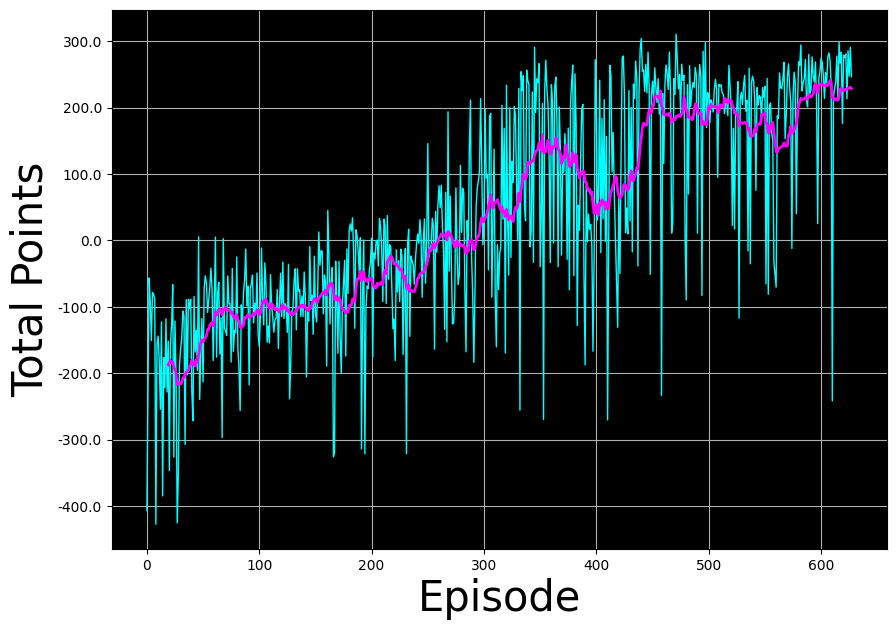

In [168]:
# Plot the point history
plot_history(total_point_history)

<a name="10"></a>
## 6 - Resultado


In [169]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In [170]:
filename = "./videos/lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)